# Определение перспективного тарифа для телеком компании

Цель исследования - провести анализ тарифов по выручке, изучить поведение клиентов и определить какой тариф лучше.


## Оглавление <a id="step-0"></a>

1. [Изучение данных](#Изучение-данных)    
2. [Подготовка данных](#Подготовка-данных)   
3. [Анализ данных](#Анализ-данных)
4. [Проверка гипотез](#Проверка-гипотез)
5. [Общий вывод](#Общий-вывод)

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st

# укажем значение параметра presicion равным 2, 
# чтобы отображать два знака после запятой (а не 6, как установлено по умолчанию.
pd.set_option('precision', 2)

# from math import ceil # для округления в большую сторону

calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")


В нашем распоряжении пять файлов: информация о тарифах, информация о клиентах, и файлы  записи их активности количество и даты звонков, сообщений, использованного трафика.

Посмотрим на предоставленные файлы.

#### Файл `tariffs.csv` общая информация о тарифах:

In [2]:
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Файл `users.csv` данные пользователей

In [3]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
116,1116,65,NaN,Петрозаводск,Альберта,Шевцова,2018-04-17,smart
123,1123,74,NaN,Краснодар,Вениамин,Устинов,2018-03-18,smart
378,1378,21,NaN,Иркутск,Евгения,Бычкова,2018-01-19,smart
465,1465,41,NaN,Омск,Пётр,Ёркин,2018-04-14,smart
399,1399,31,2018-12-25,Уфа,Алиса,Абрашина,2018-11-06,ultra
217,1217,42,NaN,Ульяновск,Ермолай,Сазонов,2018-02-23,smart
237,1237,43,NaN,Москва,Алина,Кошелева,2018-11-04,smart
33,1033,71,NaN,Москва,Лия,Бабушкина,2018-07-15,smart
246,1246,27,NaN,Санкт-Петербург,Марта,Ситникова,2018-09-26,smart
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
users['tariff'].value_counts(normalize=True)

smart    0.7
ultra    0.3
Name: tariff, dtype: float64

Выборки неравные, 70 % пользователей с тарифом Смарт и 30% - Ультра.

#### Звонки пользователей `calls.csv`

In [6]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Присутствуют нулевые значения

In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


#### Интернет траффик `internet.csv`

In [8]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


#### Сообщения `messages.csv`

In [10]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропуски в данных отсутствуют. Есть нулевые значения времени разговора. Во всех датасетах тип данных даты - object, требуется перевести в datetime.

## Подготовка данных 

#### Нулевые значения времени разговора

В таблице осуществленных звонков, присутствуют звонки с продолжительностью 0 секунд.

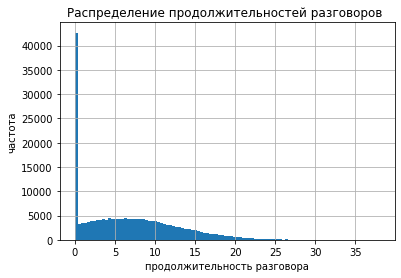

In [12]:
calls.hist("duration", bins=100)
plt.xlabel("продолжительность разговора")
plt.ylabel("частота")
plt.title("Распределение продолжительностей разговоров ")
plt.show()


In [13]:
# посчитаем долю нулевых по длительности звонков относительно общего количества
print(f"Звонков продолжительностью 0 секунд: {len(calls[calls['duration'] == 0]) / len(calls) :.2%}")


Звонков продолжительностью 0 секунд: 19.55%


Почти пятая часть всех звонков. 

Посммотрим всем ли пользователям присущ этот феномен. Есть ли пользоователи не имеющие звонкоов 0 секунд?

In [14]:
# сколько всего пользователей у которых есть хотябы один такой звонок
len(calls[calls['duration'] == 0]['user_id'].unique())

492

In [15]:
# сколько всего пользователей
len(calls['user_id'].unique())

492

Такие звонки есть у всех. Значит их наличие  не зависит от тарифа или города.

Посмотрим у всех ли пользователей одинаковое соотношение нулевых и нормальных звонков.

In [16]:
# пометим нулевые звонки в столбце 'false_calls'
calls['false_calls'] = calls['duration'].apply(lambda x: [False, True][x == 0])
calls.head(5)

,id,call_date,duration,user_id,false_calls
0,1000_0,2018-07-25,0.00,1000,True
1,1000_1,2018-08-17,0.00,1000,True
2,1000_2,2018-06-11,2.85,1000,False
3,1000_3,2018-09-21,13.80,1000,False
4,1000_4,2018-12-15,5.18,1000,False


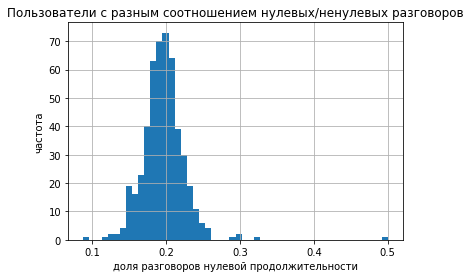

In [17]:
# сгруппируем по пользователям, посчитаем среднее по столбцу 'false_calls' и построим гистограмму
calls.groupby('user_id')['false_calls'].mean().hist(bins=50)
plt.xlabel("доля разговоров нулевой продолжительности")
plt.ylabel("частота")
plt.title("Пользователи с разным соотношением нулевых/ненулевых разговоров")
plt.show()

Выраженной группы пользователей, для которых было бы характерено другое соотношение нулевых/ненулевых звонков не наблюдается.

Такие звонки есть у всех, и похоже, что это нормальное явление. Выдвинем предположение - это исходящие звонки без соединения, то есть когда пользователи не смогли дозвониться или были сброшены. 

В описании тарифов про тарификацию подобных звонков нет. Допустим что она также нулевая, тогда на среднемесячную выручку такие звонки не влияют. 

Значения "ноль" могут повлиять на результаты исследования, если нам нужно будет рассчитывать средние продолжительности звонков. Таких задач перед нами не стоит, поэтому удалим их.



In [18]:
calls = calls.query('duration != 0')
calls

,id,call_date,duration,user_id,false_calls
2,1000_2,2018-06-11,2.85,1000,False
3,1000_3,2018-09-21,13.80,1000,False
4,1000_4,2018-12-15,5.18,1000,False
7,1000_7,2018-08-22,18.31,1000,False
8,1000_8,2018-09-15,18.44,1000,False
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,False
202603,1499_216,2018-10-18,18.83,1499,False
202604,1499_217,2018-11-10,10.81,1499,False
202605,1499_218,2018-10-06,4.27,1499,False


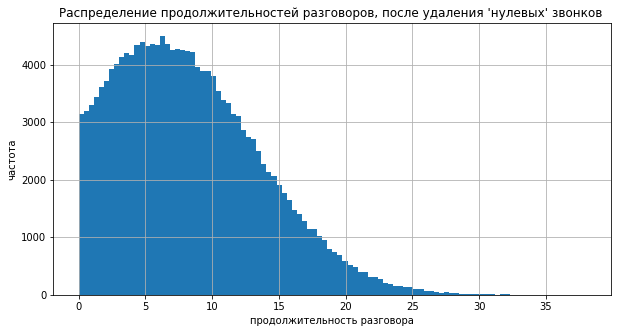

In [19]:
calls.hist("duration", figsize=(10, 5), bins=100)
plt.xlabel("продолжительность разговора")
plt.ylabel("частота")
plt.title("Распределение продолжительностей разговоров, после удаления 'нулевых' звонков ")
plt.show()

#### Проверка  на наличие дубликатов

In [20]:
users.duplicated().sum()

0

In [21]:
internet.duplicated().sum()

0

In [22]:
calls.duplicated().sum()

0

In [23]:
messages.duplicated().sum()

0

Дубликаты отсутствуют.

#### Округление времени разговора и количества использованного траффика в большую сторону.

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Что бы правильно рассчитать выручку, округлим их в большую сторону

In [24]:
internet['mb_used'] = np.ceil(internet['mb_used'])
calls['duration'] = np.ceil(calls['duration'])

In [25]:
calls.head()

,id,call_date,duration,user_id,false_calls
2,1000_2,2018-06-11,3.0,1000,False
3,1000_3,2018-09-21,14.0,1000,False
4,1000_4,2018-12-15,6.0,1000,False
7,1000_7,2018-08-22,19.0,1000,False
8,1000_8,2018-09-15,19.0,1000,False


#### Проверка значений столбца город в датафрейме `users`

In [26]:
# сравним список уникальных имен с ним же но приведенным к одному регистру
len(users['city'].value_counts()) == len(users['city'].str.lower().value_counts())

True

Названий с ошибками в регистре нет.

#### Переводим  даты в формат DateTime

In [27]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#### Создаем дополнительный столбец `month`

In [28]:
# во всех таблицах с данными создадим столбец и заполним соответствующим значением
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

#### Группируем по месяцам, суммируем количество действий пользователей

In [29]:
calls_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()

In [30]:
inet_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

In [31]:
messages_month = internet.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_month.columns = ['user_id', 'month', 'messages']

Объединяем необходимые нам столбцы в общую таблицу

In [32]:
month_activity = calls_month.merge(inet_month)
month_activity = month_activity.merge(messages_month)

In [33]:
# присоединяем таблицу с пользователями
month_activity = month_activity.merge(users[['user_id', 'city', 'tariff']])

Проверяем что получилось

In [34]:
month_activity.head(10)

,user_id,month,duration,mb_used,messages,city,tariff
0,1000,5,159.0,2256.0,5,Краснодар,ultra
1,1000,6,172.0,23257.0,49,Краснодар,ultra
2,1000,7,340.0,14016.0,29,Краснодар,ultra
3,1000,8,408.0,14070.0,29,Краснодар,ultra
4,1000,9,466.0,14581.0,27,Краснодар,ultra
5,1000,10,350.0,14717.0,27,Краснодар,ultra
6,1000,11,338.0,14768.0,24,Краснодар,ultra
7,1000,12,333.0,9827.0,21,Краснодар,ultra
8,1001,11,430.0,18452.0,55,Москва,smart
9,1001,12,414.0,14053.0,41,Москва,smart


Теперь у нас в одной таблице id пользователя, месяц, количество потребленных услуг, город и наименование тарифа. Каждая строка это один месяц одного пользователя.

#### Выручка с пользователей  по месяцам

Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану). Полученное значение сохраним в столбец `month_revenue`.

In [35]:
# для этого создадим функцию
def month_revenue_calculator(row):
    if row['tariff'] == 'ultra':
        revenue = 1950 # абонентская плата
        if row['duration'] > 3000:
            revenue = revenue + ((row['duration'] - 3000) *  1) # прибавляем к абонентской плате 
                                                                # стоимость минут сверх бесплатных
        if row['mb_used'] > 30720:
            revenue = revenue + ((row['mb_used'] - 30720) / 1000 * 150) # 150 рублей за каждый Гб сверх бесплатных
        if row['messages'] > 1000:
            revenue = revenue + ((row['messages'] - 1000) *  1) # и по рублю за сообщение
    if row['tariff'] == 'smart':
        revenue = 550 # абонентская плата
        if row['duration'] > 500:
            revenue = revenue + ((row['duration'] - 500) *  3) # прибавляем к абонентской плате 
                                                               # стоимость минут сверх бесплатных
        if row['mb_used'] > 15360:
            revenue = revenue + ((row['mb_used'] - 15360) / 1000 * 200) # 200 рублей за каждый Гб сверх бесплатных
        if row['messages'] > 50:
            revenue = revenue + ((row['messages'] - 50) *  3) # и по 3 рубля за сообщение сверх 50-ти
    return revenue

In [36]:
month_activity['month_revenue'] = month_activity.apply(month_revenue_calculator, axis=1)

In [37]:
month_activity.head(10)

,user_id,month,duration,mb_used,messages,city,tariff,month_revenue
0,1000,5,159.0,2256.0,5,Краснодар,ultra,1950.0
1,1000,6,172.0,23257.0,49,Краснодар,ultra,1950.0
2,1000,7,340.0,14016.0,29,Краснодар,ultra,1950.0
3,1000,8,408.0,14070.0,29,Краснодар,ultra,1950.0
4,1000,9,466.0,14581.0,27,Краснодар,ultra,1950.0
5,1000,10,350.0,14717.0,27,Краснодар,ultra,1950.0
6,1000,11,338.0,14768.0,24,Краснодар,ultra,1950.0
7,1000,12,333.0,9827.0,21,Краснодар,ultra,1950.0
8,1001,11,430.0,18452.0,55,Москва,smart,1183.4
9,1001,12,414.0,14053.0,41,Москва,smart,550.0


Бросается в глаза, как минимум у одного пользователя месячная выручка не превышает абонентской платы. 

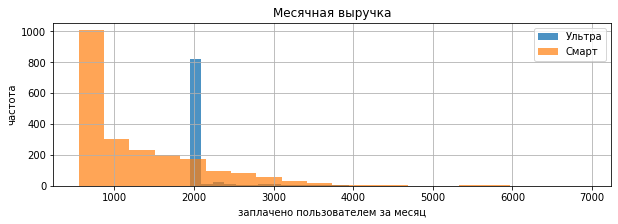

In [38]:
ax1 = month_activity.query('tariff == "ultra"')['month_revenue'].hist( bins=20, alpha=0.8, figsize=(10, 3), label="Ультра")
ax2 = month_activity.query('tariff == "smart"')['month_revenue'].hist( bins=20, alpha=0.7, label="Смарт")
ax1.legend()
ax1.set_title('Месячная выручка')
plt.xlabel("заплачено пользователем за месяц")
plt.ylabel("частота")
plt.show()

Почти все пользователи Ультра не платят больше чем размер абонентской платы.

Средняя ежемесячная выручка с пользователя тарифа Ультра:

In [39]:
month_activity.query('tariff == "ultra"')['month_revenue'].mean()

2065.8520277481325

Средняя ежемесячная выручка с пользователя тарифа Смарт:

In [40]:
month_activity.query('tariff == "smart"')['month_revenue'].mean()

1250.438828828829

Распределение по месячной выручке с пользователя нельзя считать нормальным. Минимальное значение ежемесячной стоимости услуг - это размер абонентской платы, это значение и является самым распространенным для тарифа. В среднем пользователи Ультра платят в 1,6 раза больше в месяц чем пользователи Смарт.


In [53]:
#users.groupby('tariff')['user_id'].count().reset_index()

## Анализ данных

Изучим поведение пользователей разных тарифов. Кто сколько тратит разговорных минут, сообщений, сколько использует интернет трафика.

### Потребность в минутах разговора

Построим гистограммы потраченного времени на разговоры и посчитаем среднее количество, дисперсию и стандартное отклонение (для удобства сведем эти значения в небольшую таблицу).

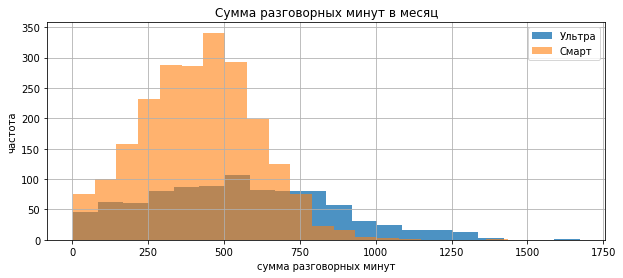

,tariff,mean,variance,std,need
0,ultra,551.23,93024.80,305.00,1466.23
1,smart,419.61,35656.62,188.83,986.10


In [42]:
# строим графики
ax1 = month_activity.query('tariff == "ultra"')['duration'].hist( bins=20, alpha=0.8, label="Ультра", figsize=(10, 4))
ax2 = month_activity.query('tariff == "smart"')['duration'].hist( bins=20, alpha=0.6, label="Смарт")
ax1.legend()
ax1.set_title('Сумма разговорных минут в месяц')
plt.xlabel("сумма разговорных минут")
plt.ylabel("частота")
plt.show()

# создаем датафрейм
calls_match = pd.DataFrame({'tariff': ['ultra', 'smart']})
# считаем среднее 
calls_match['mean'] = calls_match['tariff'].apply(
    lambda x: month_activity[month_activity['tariff'] == x]['duration'].mean())
# считаем дисперсию
calls_match['variance'] = calls_match['tariff'].apply(
    lambda x: np.var(month_activity[month_activity['tariff'] == x]['duration']))
# считаем стандартное отклонение
calls_match['std'] = calls_match['tariff'].apply(
    lambda x: np.std(month_activity[month_activity['tariff'] == x]['duration']))
# считаем верхнюю границу трех стандартных отклонений, такое количество минут в пакете удовлетворило бы 
# 99% пользователей соответствующего тарифа 
calls_match['need'] = calls_match['mean'] + (calls_match['std'] * 3)
calls_match

calls_match

В столбце `need` посчитана потребность в минутах в месяц. Максимальное значение которое удовлетворит потребностть 99% клиентов. Это верхняя граница области значений, лежащая на расстоянии 3 стандартных отклонений от среднего.


При небольшом отличии в среднем количестве потраченных минут, потребность в минутах разговора у пользователей Ультра в полтора раза больше, чем у Смарт.

Что бы утверждать о том, что поведение пользователей на разных тарифах отличается, проверим статистические гипотезы.
За нулевую гипотезу примем утверждение, что среднее количество разговорных минут которое ежемесячно тратят пользователи равно для разных тарифов.

In [43]:
# сохраним выборки в отдельные датасеты
calls_ultra = month_activity.query('tariff == "ultra"')['duration']
calls_smart = month_activity.query('tariff == "smart"')['duration']

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
    
results = st.ttest_ind(
    calls_ultra, 
    calls_smart, 
    equal_var = False # 'equal_var' зададим 'False' так как дисперсии отличаются
)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 1.1546958296704824e-32
Отвергаем нулевую гипотезу


p-значение близко к нулю.  Если предположить, что средние значения количества звонков на разных тарифах одинаковые, то вероянтость получить подобное отличие из за случайности практически отсутствует.


In [44]:
calls_match.loc[0, 'mean'] / calls_match.loc[1, 'mean']

1.3136912496685436

Пользователи Ультра разговаривают на 30% больше и эту разницу можно считать статистически значимой.

### Потребность в сообщениях

Построим гистограммы количества посланных сообщений в месяц и соберем аналогичную таблицу со средним, дисперсией и стандартным отклонением.

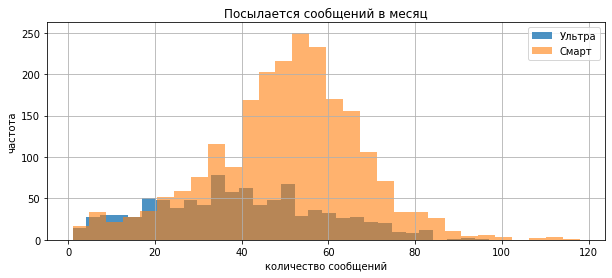

,tariff,mean,variance,std,need
0,ultra,38.84,374.29,19.35,96.88
1,smart,50.07,300.92,17.35,102.11


In [45]:
ax1 = month_activity.query('tariff == "ultra"')['messages'].hist( bins=30, alpha=0.8, label="Ультра", figsize=(10, 4))
ax2 = month_activity.query('tariff == "smart"')['messages'].hist( bins=30, alpha=0.6, label="Смарт")
ax1.legend()
ax1.set_title('Посылается сообщений в месяц')
plt.xlabel("количество сообщений")
plt.ylabel("частота")
plt.show()

messages_match = pd.DataFrame({'tariff': ['ultra', 'smart']})
messages_match['mean'] = messages_match['tariff'].apply(
    lambda x: month_activity[month_activity['tariff'] == x]['messages'].mean())

messages_match['variance'] = messages_match['tariff'].apply(
    lambda x: np.var(month_activity[month_activity['tariff'] == x]['messages']))

messages_match['std'] = messages_match['tariff'].apply(
    lambda x: np.std(month_activity[month_activity['tariff'] == x]['messages']))

messages_match['need'] = messages_match['mean'] + (messages_match['std'] * 3)


messages_match

Потребность в сообщениях у пользователей тарифа Смарт в два раза выше, чем в пакете. Пользователи тарифа Ультра пишут сообщения реже, и не расходуют количество из пакета.

Проверим статистические гипотезы, приняв за нулевую гипотезу, что среднее количество сообщений отправляемых пользователями разных тарифов - не отличается.

In [46]:
# сохраним выборки в отдельные датасеты
messages_ultra = month_activity.query('tariff == "ultra"')['messages']
messages_smart = month_activity.query('tariff == "smart"')['messages']

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
    
results = st.ttest_ind(
    messages_ultra, 
    messages_smart, 
    # equal_var = False # 'equal_var' зададим 'False' так как дисперсии отличаются
)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 9.981864485058976e-56
Отвергаем нулевую гипотезу


р-значение еще меньше и ближе к нулю чем в случае с количеством потраченных минут. Вероятность того что средние значения выборок равны, а расхождение случайно близка к нулю.


### Потребность в интернет траффике

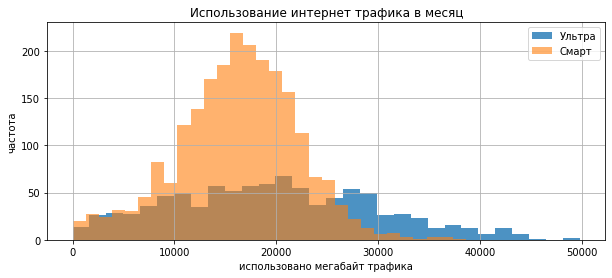

,tariff,mean,variance,std,need
0,ultra,19697.67,9.96e+07,9982.45,49645.03
1,smart,16238.77,3.45e+07,5873.35,33858.82


In [47]:
ax1 = month_activity.query('tariff == "ultra"')['mb_used'].hist( bins=30, alpha=0.8, label="Ультра", figsize=(10, 4))
ax2 = month_activity.query('tariff == "smart"')['mb_used'].hist( bins=30, alpha=0.6, label="Смарт")
ax1.legend()
ax1.set_title('Использование интернет трафика в месяц')
plt.xlabel("использовано мегабайт трафика")
plt.ylabel("частота")
plt.show()

mb_used_match = pd.DataFrame({'tariff': ['ultra', 'smart']})
mb_used_match['mean'] = mb_used_match['tariff'].apply(
    lambda x: month_activity[month_activity['tariff'] == x]['mb_used'].mean())

mb_used_match['variance'] = mb_used_match['tariff'].apply(
    lambda x: np.var(month_activity[month_activity['tariff'] == x]['mb_used']))

mb_used_match['std'] = mb_used_match['tariff'].apply(
    lambda x: np.std(month_activity[month_activity['tariff'] == x]['mb_used']))

mb_used_match['need'] = mb_used_match['mean'] + (mb_used_match['std'] * 3)

mb_used_match

Среднее количество месячного трафика пользователей Ультры отличается примерно на 20%. 
Среднее тарифа Смарт близко к количеству трафика в пакете услуг. Можно предположить между ними причинно-следственную связь. 
По примеру сравнения предыдущих показателей, можно определенно сказать, разница в пользовании интерентом есть и она статистически значима.


## Проверка гипотез

### Сравнение выручки разных тарифов

Гипотезу о том, что средняя выручка пользователей тарифов Ультра и Смарт различается примем за альтернативную.

За нулевую гипотезу примем, что средние значения месячной выручки с пользователя, на разных тарифах равны.

In [48]:
# сохраним выборки в отдельные датасеты
revenue_ultra = month_activity.query('tariff == "ultra"')['month_revenue']
revenue_smart = month_activity.query('tariff == "smart"')['month_revenue']

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
    
results = st.ttest_ind(
    revenue_ultra, 
    revenue_smart)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.7882336955441537e-164
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. Если предположить, что средние выручки равны, то вероятность получить случайно такое расхождение практически нулевая.
Cредняя выручка пользователей тарифов Ультра и Смарт различается.

### Сравнение выручки разных городов

Гипотезу о том, что ссредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, примем за альтернативную. За нулевую гипотезу примем утверждение что средние выручки Москвы и регионов равны.

In [49]:
# сохраним выборки в отдельные датасеты
revenue_msk = month_activity.query('city == "Москва"')['month_revenue']
revenue_not_msk = month_activity.query('city != "Москва"')['month_revenue']

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
    
results = st.ttest_ind(
    revenue_msk, 
    revenue_not_msk
)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.36103665409531094
Не получилось отвергнуть нулевую гипотезу


In [50]:
print('Средняя выручка с пользователя в месяц в Москве:', revenue_msk.mean())
print('Средняя выручка с пользователя в месяц в других регионах:', revenue_not_msk.mean())

Средняя выручка с пользователя в месяц в Москве: 1519.4108196721313
Средняя выручка с пользователя в месяц в других регионах: 1485.9980172752257


Если нулевая гипотеза верна, и средняя выручка в Москве и регионах одинакова, то существует достаточно высокая вероятность ( 36% ) получить такое отличие случайно. 
Отвергнуть нулевую гипотезу нельзя. Отличие средней выручки в Москве и в регионах статистически не значимо.

## Общий вывод

В исходных данных особых проблем не обнаружено. 

Основной вопрос к техническим спаеиалистам, это присутствие в выборке 19,55% телефонных звонков продолжительностью 0 секунд. Такие звонки могли бы повлиять на расчет средней продолжительности разговоров если бы мы ее производили. Их присутствие или наличие никак не повлияло бы на результат исследования, в данной работе они были удалены.


В среднем выручка с пользователя тарифа Ультра в 1,6 раз больше чем с пользователя Смарт. 

Услуг при этом пользователи Ультра потребляют больше, но не пропорционально (среднее количество разговорных минут в месяц больше в 1,3 раза, интернет трафика больше в 1,2 раза, а сообщения наоборот пишут реже чем пользователи тарифа Смарт).

В среднем пользователи тарифа Ультра больше разговариваривают и пользуются интернетом,чем Смарт. Смарт больше чем Ультра шлет сообщения. 
При оценке поведения, нужно учитывать условия тарифов. Разные размеры пакетов услуг, возможно и провоцируют на разное потребительское поведение. 

Различие в средней выручке между пользователями из Москвы и из других регионов статистически незначимо. Можно сказать что поведение пользователей в разных регионах не отличается. 
